# Time Series Forecasting using LSTM: Single-time-step Predictions


In this notebook, we describe the steps for single-time-step predictions for a wesather forecasting problem. We train a LSTM model for making predictions.

The notebook is adapted from the following two Keras tutorials.
- https://keras.io/examples/timeseries/timeseries_weather_forecasting/
- https://keras.io/examples/timeseries/timeseries_classification_transformer/

## Dataset
We use the the Jena Climate dataset by the Max Planck Institute for Biogeochemistry.
https://www.bgc-jena.mpg.de/wetter/

The dataset has 15 features such as datetime, temperature, pressure, humidity, etc. There are 420551 observations (time steps), each recorded once per 10 minutes (6 times per hour).

- Total observations = 420551 (an observation is recorded per 10 minutes)
- Total features = 15

Though 6 observations are recorded every hour, we use only one observation per hour to train the model since no drastic change is expected within an hour. 


## Single-time-step Predictions

For the single-time-step predictions, we need to decide the length of each sequence and the a future location on the sequence that we want to predict.

We chose the sequence length to be 120 hours (on the 10 minutes recording scale, the length spans 720 observations).

We want to predict an observation which is 12 hours (on the 10 minutes recording scale, it is 72 observations) future from the last observation in the sequence. This gap is added to make the prediction slightly non-trivial. 

The first training sequence is as follows (though we use only one observation per hour):

        0 1 2 ... 719

The index of the location of the first prediction (720 training observations + 72 "gap" observations):
        
        792



For training the model, we use ~300,000 samples (observations). These observations are divided into constant length sequences.
- Each sequence length = 120 hours (720 observations)
- Every sequence has a label (after the 72 observations)

Therefore,
- A sample = 120 hours (720 observations) + 1 label
- A batch contains multiple samples.


In [1]:
from zipfile import ZipFile
import os

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2023-05-17 19:04:50.034136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the Dataset

In [3]:
'''
Download the Dataset
'''
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = tf.keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"


'''
Load the dataset as a Pandas DataFRame object
'''
df = pd.read_csv(csv_path)
print("Dimension of the data: ", df.shape)
df.info()

Dimension of the data:  (420551, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB

## Raw Data Visualization

We plot each feature pattern over the time period from 2009 to 2016. The plots help to identify the anomalies.

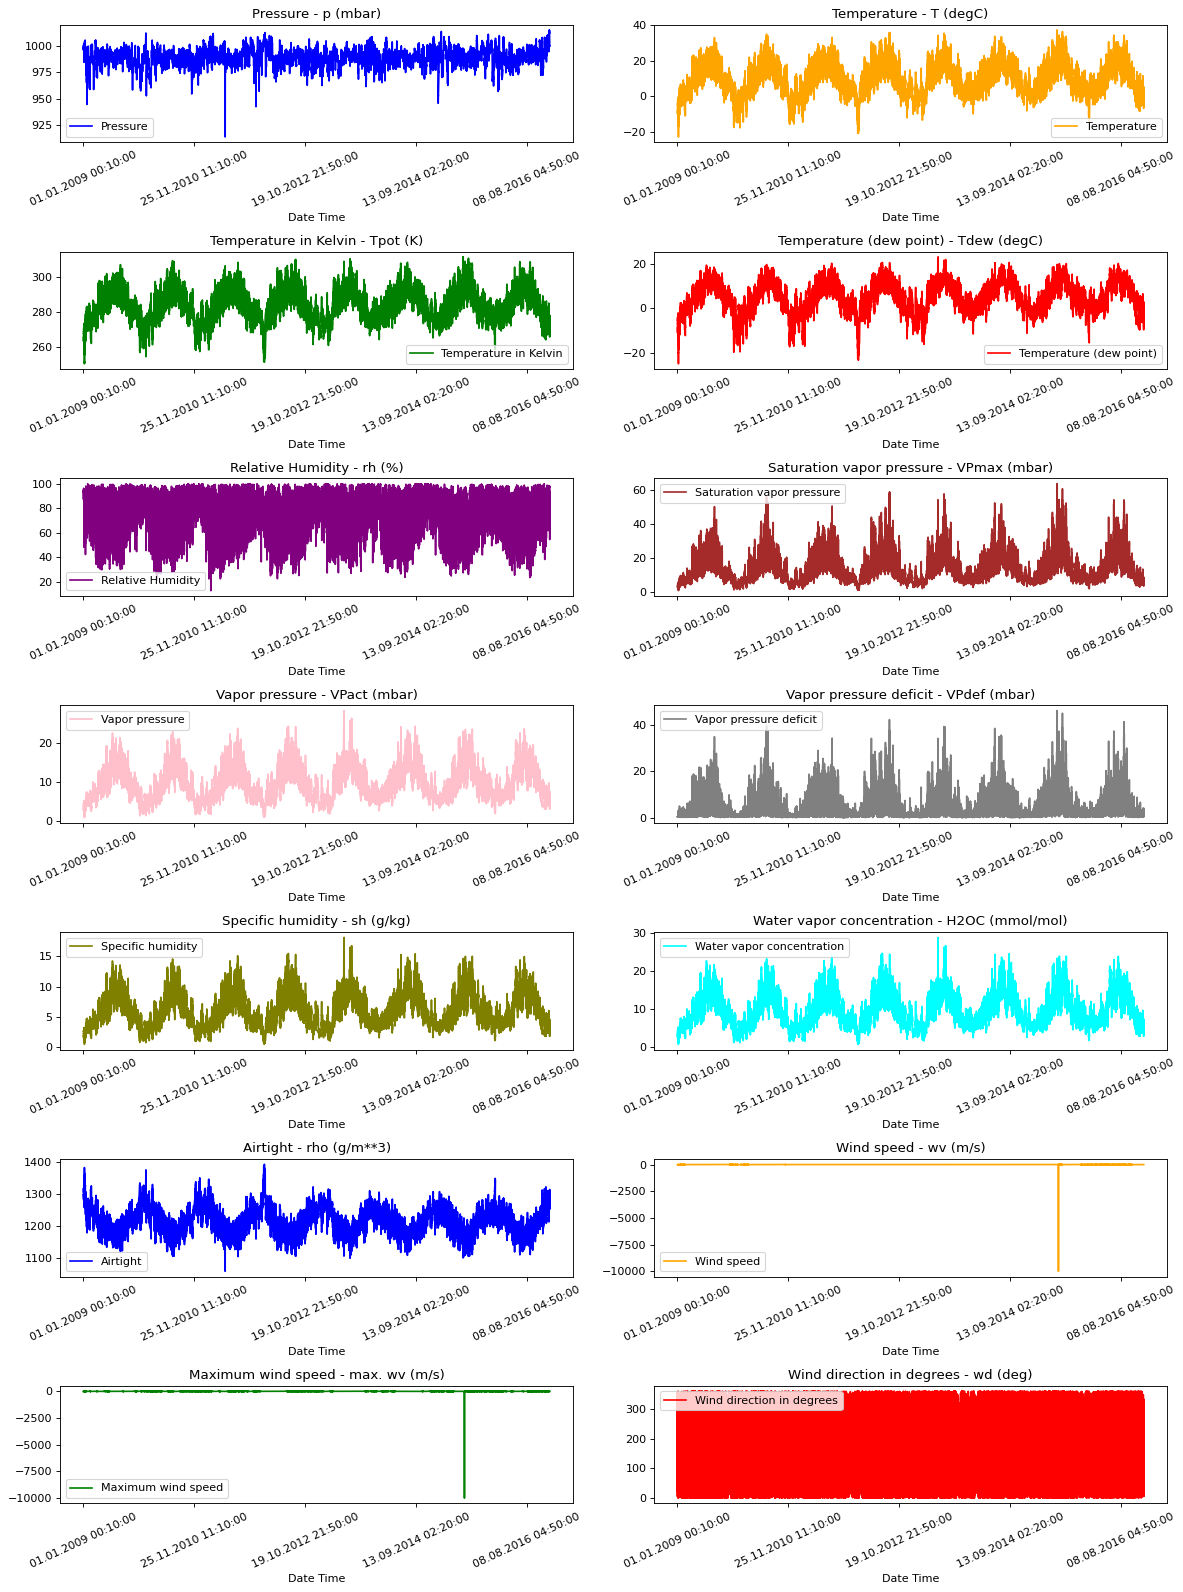

In [4]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

## Feature Correlation

We create a heat map to show the correlation between different features.

/var/folders/w4/2jg9qqrd2nz32dyc_cr68d580000gp/T/ipykernel_72277/3897922630.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(data.corr())


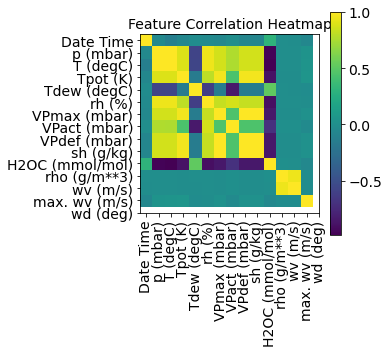

In [5]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

## Data Preprocessing

As mentioned earlier, we use one obervation per hour by resampling from 6 observations/hour.

Since the length of a sequence is 120, we use 720 observations-long sequence for prediction (training). The prediction location on the sequence is after 12 hours or 72 observations. This observation is used as a label.


### Normalization
Since every feature has values with varying ranges, we do normalization to confine feature values to a range of [0, 1] before training a neural network. We do this by subtracting the mean and dividing by the standard deviation of each feature.

### Train-Test Split
71.5 % of the data will be used to train the model, i.e. 300,693 rows. 

In [7]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6  # It is required to determine the length of a sequence

past = 720  # Length of a sequence on the original observations (5 days)
future = 72  # Prediction is made after 72 observations (12 hours)
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

## Feature Selection

From the correlation heatmap, we identify that few parameters like Relative Humidity and Specific Humidity are redundant. This, we select only the relevant features for learning.

In [8]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

print("All data: ", features.shape)
print("Train data: ", train_data.shape)
print("Val data: ", val_data.shape)

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed
All data:  (420551, 7)
Train data:  (300693, 7)
Val data:  (119858, 7)


## Create Train & Validation Datasets


In [9]:
start = past + future # Defines the start position of the labels, i.e., from the 792nd observation (720 + 72)
end = start + train_split # Defines the end position of the labels

'''
Creates train data and labels
'''
x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]] # Labels start from the 792nd observation (720 + 72)

print("\nx_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)


'''
Defines the length of a sequence:
- (720 observations in a sequence) divided by (6 observations per hour)
'''
sequence_length = int(past / step)
print("\nsequence_length: ", sequence_length)

'''
Create a Dataset object for the training data.
For this, we use the 
keras.preprocessing.timeseries_dataset_from_array function.
It takes in a sequence of data-points gathered at equal intervals, 
along with time series parameters such as length of the sequences/windows, 
spacing between two sequence/windows, etc., to produce batches of sub-timeseries inputs and 
targets sampled from the main timeseries.
'''

dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)





'''
Create the validation data
'''
x_end = len(val_data) - past - future
label_start = train_split + past + future


x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]


'''
Create a Dataset object for the training data.
For this, we use the 
keras.preprocessing.timeseries_dataset_from_array function.
'''
dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("\nInput shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


x_train shape:  (300693, 7)
y_train shape:  (300693, 1)

sequence_length:  120


2023-05-17 19:05:56.428514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Input shape: (256, 120, 7)
Target shape: (256, 1)


## Create a Model

In [11]:
inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = tf.keras.layers.LSTM(32)(inputs)
outputs = tf.keras.layers.Dense(1)(lstm_out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [14]:
path_checkpoint = "Weather_forecasting_half_day_LSTM_checkpoint.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.2230 - mean_absolute_error: 0.3538
Epoch 1: val_loss improved from inf to 0.17555, saving model to Weather_forecasting_half_day_LSTM_checkpoint.h5
1172/1172 [==============================] - 203s 172ms/step - loss: 0.2230 - mean_absolute_error: 0.3538 - val_loss: 0.1755 - val_mean_absolute_error: 0.3305
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1318 - mean_absolute_error: 0.2807
Epoch 2: val_loss improved from 0.17555 to 0.14002, saving model to Weather_forecasting_half_day_LSTM_checkpoint.h5
1172/1172 [==============================] - 213s 181ms/step - loss: 0.1318 - mean_absolute_error: 0.2807 - val_loss: 0.1400 - val_mean_absolute_error: 0.2936
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1138 - mean_absolute_error: 0.2631
Epoch 3: val_loss did not improve from 0.14002
1172/1172 [==============================] - 192s 163ms/step - loss: 0.1138 - me

## Visualize the Train & Validation Loss

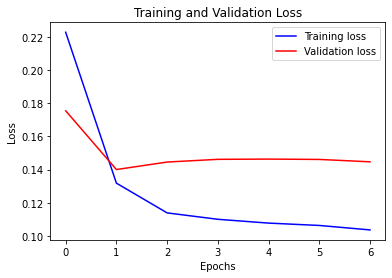

In [15]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Model Evaluation: using the History Object

In [16]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

train_MAE = history.history['mean_absolute_error']
val_MAE = history.history['val_mean_absolute_error']


train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Read the last value from the list that represents final epoch statistics
print("\nMAE (train): ", train_MAE[-1])
print("MAE (val): ", val_MAE[-1])

print("\nLoss (train): ", train_loss[-1])
print("Loss (val): ", val_loss[-1])

Epochs:  7

MAE (train):  0.25141483545303345
MAE (val):  0.2969180643558502

Loss (train):  0.10353871434926987
Loss (val):  0.14469541609287262


## Model Evaluation: using the evaluate() Method on the Batched Val Dataset Object

In [17]:
val_loss_dataset, val_MAE_dataset = model.evaluate(dataset_val, verbose=0)

print("\nLoss (val) from Dataset: ", val_loss_dataset)
print("MAE (val) from Dataset: ", val_MAE_dataset)


Loss (val) from Dataset:  0.14469541609287262
MAE (val) from Dataset:  0.2969180643558502


## Prediction

We make predictions for 5 sets of values from validation set.

8/8 [==============================] - 1s 12ms/step


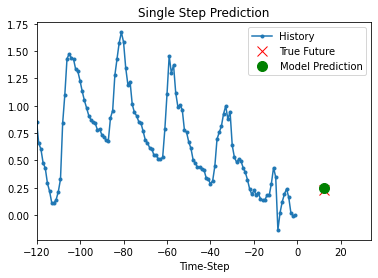

8/8 [==============================] - 0s 12ms/step


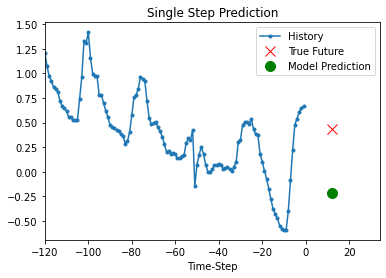

8/8 [==============================] - 0s 12ms/step


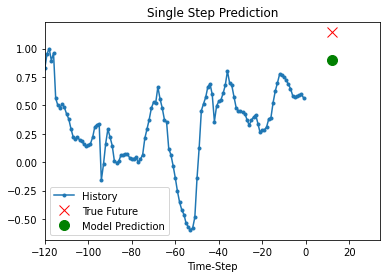

8/8 [==============================] - 0s 12ms/step


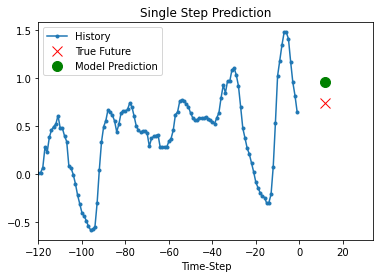

8/8 [==============================] - 0s 11ms/step


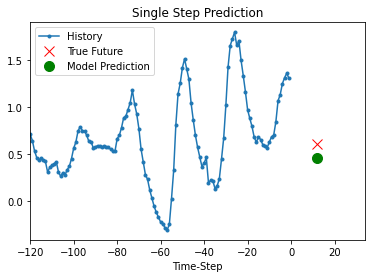

In [18]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


# The future step for plotting the prections
future_step = int(future/step)

for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        future_step,
        "Single Step Prediction",
    )